In [1]:
### Use the Bayesian clasifer to detect the ground in a greenhouse
### @Dr. Zhaozheng Yin, Stony Brook University, Fall 2021
### housekeeping
import cv2
import numpy as  np
import matplotlib.pyplot as plt

In [2]:
### File directory
# Change the directory to run the program
# Change the trainning images to see different results
datadir = '/Users/yajiewang/Downloads/353img/Tunnel-'
trainingImages = [2]
testingImages = [1, 3]
### Parameters
nDim = 256 #number of bins for the color likelihood distribution. This is too big. Try to have smaller bins such as 8, 16, 32, etc.

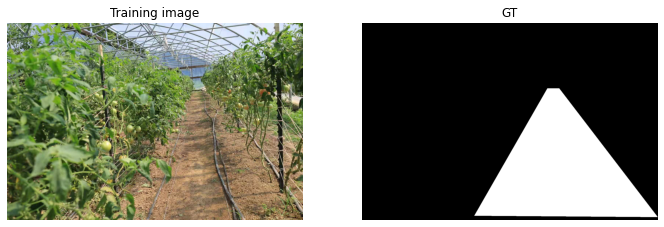

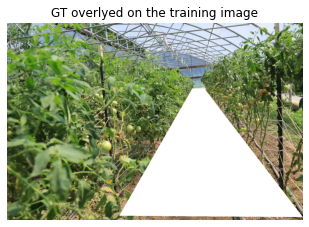

Pr_y_equalsTo_1: 0.21465420667581162


In [3]:
### Training process
Pr_x_given_y_equalsTo_1 = np.zeros((nDim,nDim,nDim)) #likelihood for the ground class
Pr_x_given_y_equalsTo_0 = np.zeros((nDim,nDim,nDim)) #likelihood for the non-ground class
N_GroundPixels = 0 #Pr_y_equalsTo_1 = N_GroundPixels/N_totalPixels
for iFile in trainingImages:
    ### Load the training image and labeled image regions
    origIm = cv2.imread(datadir + '0' + str(iFile) + '.jpeg')   
    labels = cv2.imread(datadir + '0' + str(iFile) + '-label.png', cv2.IMREAD_GRAYSCALE) #label=1 representing the ground class
    labels = cv2.threshold(labels, 127, 1, cv2.THRESH_BINARY)[1]
    
    ### Visualization input image and its labels
    nrows, ncols = origIm.shape[0], origIm.shape[1]
    showIm = origIm.copy() 
    showIm[labels==1] = 255;
    
    ### Be sure to convert the color space of the image from BGR (Opencv) to RGB (Matplotlib) before you show a color image read from OpenCV
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(origIm, cv2.COLOR_BGR2RGB))
    plt.title('Training image')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(labels, 'gray')
    plt.title('GT')
    plt.axis("off")
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(showIm, cv2.COLOR_BGR2RGB))
    plt.title('GT overlyed on the training image')
    plt.axis("off")

    plt.show()
# see how labels work    
#     print (labels[800,1000])
#     print (origIm[1,1])    

    ### Prior-related codes:
    
    # Fill in your code here
    
    # Image size = nrows * ncols = 1080 * 1620
    
    # Count the ground pixels from the ground truth labels
    
    N_totalPixels = nrows * ncols

    for i in range(0,nrows):
        for j in range(0,ncols):
            if labels[i][j] == 1:
                N_GroundPixels += 1
                
    Pr_y_equalsTo_1 = N_GroundPixels / N_totalPixels
    print ("Pr_y_equalsTo_1: " + str(Pr_y_equalsTo_1))
                


    ### Likelihood-related codes:
    
    # Fill in your code here
    # Get the RGB values of the ground pixels and calculate the likelihood of ground and non-ground regions
    
    for i in range(0,nrows):
        for j in range(0,ncols):
            b = origIm[i][j][0]
            g = origIm[i][j][1]
            r = origIm[i][j][2]
            if labels[i,j] == 1:
                Pr_x_given_y_equalsTo_1[b][g][r] += 1
            else:
                Pr_x_given_y_equalsTo_0[b][g][r] += 1
    
    
    for i in range(0, nDim):
        for j in range(0, nDim):
            for k in range(0, nDim):
                Pr_x_given_y_equalsTo_1[i][j][k] /= N_GroundPixels
                Pr_x_given_y_equalsTo_0[i][j][k] /= (N_totalPixels - N_GroundPixels)
                    


### Some other codes such as normalizing the likelihood/prior and computing Pr_y_equalsTo_0:

# Fill in your code here

#  Pr_y_equalsTo_0 = 1 - Pr_y_equalsTo_1
#  I skip it and use (1 - Pr_y_equalsTo_1) directly


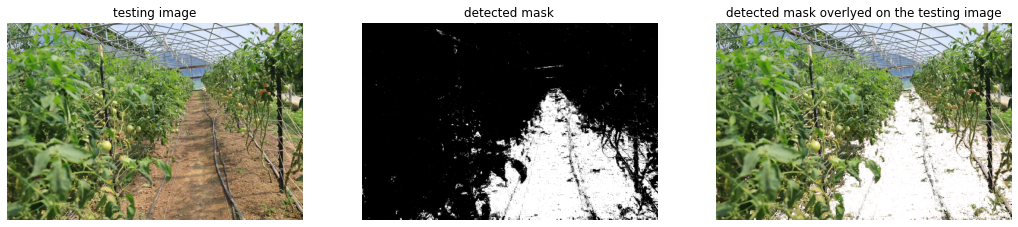

Micro-average precision: 0.8258387497983462
Micro-average recall: 0.8451082253387617
Micro-average fscore: 0.8353623791093606


In [4]:
### Testing
# from sklearn.metrics import confusion_matrix

truePositives = 0;
falsePositives = 0;
falseNegatives = 0;
testingImages = [2]

for iFile in testingImages:  
    ### Load the testing image and ground truth regions  
    origIm = cv2.imread(datadir + '0' + str(iFile) + '.jpeg')
    gtMask = cv2.imread(datadir + '0' + str(iFile) + '-label.png', cv2.IMREAD_GRAYSCALE)
    gtMask = cv2.threshold(gtMask, 127, 1, cv2.THRESH_BINARY)[1]
    nrows, ncols = origIm.shape[0], origIm.shape[1]
    
    ### Define the posteriors
    Pr_y_equalsTo_1_given_x = np.zeros((nrows,ncols));   
    Pr_y_equalsTo_0_given_x = np.zeros((nrows,ncols));

    ### Codes to infer the posterior:
    
    for i in range(0,nrows):
        for j in range(0,ncols):
            b = origIm[i][j][0]
            g = origIm[i][j][1]
            r = origIm[i][j][2]
            Pr_y_equalsTo_1_given_x[i][j] = Pr_x_given_y_equalsTo_1[b][g][r] * Pr_y_equalsTo_1
            Pr_y_equalsTo_0_given_x[i][j] = Pr_x_given_y_equalsTo_0[b][g][r] * (1 - Pr_y_equalsTo_1)

    ### Codes to obtain the final classification result (detectedMask):
    
    # Fill in your code here
    # We can simplify the equation because the denominators are the same. // Pr(x)
    
    detectedMask = np.zeros((nrows,ncols))
    
    for i in range(0,nrows):
        for j in range(0,ncols):
            if (Pr_y_equalsTo_1_given_x[i][j] > Pr_y_equalsTo_0_given_x[i][j]):
                detectedMask[i][j] = 1
            else:
                detectedMask[i][j] = 0
    
    ### Codes to calculate the TP, FP, FN:
    
    # Fill in your code here
    
    # Calculate the TP, FP, FN by their definitions
    # Gound truth is gtMask and prediction is detectedMask
 
    for i in range(0,nrows):
        for j in range(0,ncols):
            if (gtMask[i][j] == 1 and detectedMask[i][j] == 1):
                truePositives += 1
            if (gtMask[i][j] == 0 and detectedMask[i][j] == 1):
                falsePositives += 1
            if (gtMask[i][j] == 1 and detectedMask[i][j] == 0):
                falseNegatives += 1
    
    ### Visualize the classification results
    showIm = origIm.copy()
    showIm[detectedMask==1] = 255;

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(origIm, cv2.COLOR_BGR2RGB))
    plt.title('testing image')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(detectedMask, 'gray')
    plt.title('detected mask')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(showIm, cv2.COLOR_BGR2RGB))
    plt.title('detected mask overlyed on the testing image')
    plt.axis("off")
    plt.show()

### Codes to calculate the precision, recall, and fscore:


# Fill in your code here
# Calculate the precision, recall, and fscore by using formulas

precision = truePositives / (truePositives + falsePositives)
recall = truePositives / (truePositives + falseNegatives)
fscore = 2 * precision * recall / (precision + recall)

# Print the results we get
# print("TP: " + str(truePositives))
# print("FP: " + str(falsePositives))
# print("FN: " + str(falseNegatives))

print("Micro-average precision: " + str(precision))
print("Micro-average recall: " + str(recall))
print("Micro-average fscore: " + str(fscore))


